In [73]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
import sys 

project_root = Path().cwd()
scripts_dir = project_root / "src" / "scripts"
sys.path.insert(0, str(scripts_dir))

import numpy as np 
import scipy.stats as stats
import scipy.io as io
import os 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
import seaborn as sns
import process_2p as p2p
import lick_behav_analysis as behav
import classify_2p as c2p
import trackcells as t2p
from scalebars import add_scalebar
from scipy.stats import chi2_contingency
import scipy.io as sio
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests



In [74]:
folder = '/Users/savani/Documents/PangLab/TwoPhotonAnalysis/src/data/fasted 30 sucrose'
all_avg_f, all_baseline_data, all_aligned_f, all_f = p2p.process_2p_folder(folder, align = 'lick', success = 'success')
folder = '/Users/savani/Documents/PangLab/TwoPhotonAnalysis/src/data/fed 30 sucrose'
all_avg_fed, all_baseline_data_fed, all_aligned_fed, all_fed = p2p.process_2p_folder(folder, align = 'lick', success = 'success')

In [75]:
len(all_aligned_f)
all_recordings = all_aligned_f + all_aligned_fed
all_states = ['fasted'] * len(all_aligned_f) + ['fed'] * len(all_aligned_fed)

In [78]:
''''
Features: Mean and max fluorescence in 3s window after first lick for each cell on each trial 
Response: State, 0 or 1 

'''
# Parameters
fps = 15
lick_frame = 75
post_window_s = 2
post_window_frames = int(post_window_s * fps)

def extract_features(data_list, state_list):
    X, y = [], []
    for data, state in zip(data_list, state_list):
        cells, trials, frames = data.shape

        # Loop over trials
        for t in range(trials):
            trial_data = data[:, t, lick_frame:lick_frame + post_window_frames]
            avg_vals = trial_data.mean(axis=1)
            max_vals = trial_data.max(axis=1)
            feat = np.vstack([avg_vals, max_vals]).T  # shape: [cells, 2]

            X.append(feat)
            y += [1 if state == 'fed' else 0] * cells

    X = np.concatenate(X, axis=0)
    y = np.array(y)
    return X, y


def decode_optimized(X, y, n_iter=100, n_jobs=3):
    actual_acc = []
    shuffle_acc = []

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC())
    ])

    param_grid = [
        {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10]},
        {'svc__kernel': ['rbf'], 'svc__C': [0.01, 0.1, 1, 10], 'svc__gamma': [0.01, 0.1, 1, 10]}
    ]

    skf_outer = StratifiedKFold(n_splits=10)

    for i in range(n_iter):
        print(f"Shuffle iteration {i}/{n_iter}")

        # Subsample 90% of cells
        n_samples = int(0.9 * len(X))
        idx = np.random.choice(len(X), size=n_samples, replace=False)
        X_sub, y_sub = X[idx], y[idx]

        # GridSearchCV with pipeline and parallel jobs
        clf = GridSearchCV(pipe, param_grid, cv=skf_outer, scoring='accuracy', n_jobs=n_jobs)
        clf.fit(X_sub, y_sub)
        actual_acc.append(clf.best_score_)

        # Shuffle labels with new random state every iteration
        y_shuf = shuffle(y_sub, random_state=None)
        clf_shuf = GridSearchCV(pipe, param_grid, cv=skf_outer, scoring='accuracy', n_jobs=n_jobs)
        clf_shuf.fit(X_sub, y_shuf)
        shuffle_acc.append(clf_shuf.best_score_)

    return np.array(actual_acc), np.array(shuffle_acc)

# Run decoding
X, y = extract_features(all_recordings, all_states)
acc_real, acc_shuffled = decode_optimized(X,y)


Shuffle iteration 0/100
Shuffle iteration 1/100
Shuffle iteration 2/100
Shuffle iteration 3/100
Shuffle iteration 4/100
Shuffle iteration 5/100
Shuffle iteration 6/100
Shuffle iteration 7/100
Shuffle iteration 8/100
Shuffle iteration 9/100
Shuffle iteration 10/100
Shuffle iteration 11/100
Shuffle iteration 12/100
Shuffle iteration 13/100
Shuffle iteration 14/100
Shuffle iteration 15/100
Shuffle iteration 16/100
Shuffle iteration 17/100
Shuffle iteration 18/100
Shuffle iteration 19/100
Shuffle iteration 20/100
Shuffle iteration 21/100
Shuffle iteration 22/100
Shuffle iteration 23/100
Shuffle iteration 24/100
Shuffle iteration 25/100
Shuffle iteration 26/100
Shuffle iteration 27/100
Shuffle iteration 28/100
Shuffle iteration 29/100
Shuffle iteration 30/100
Shuffle iteration 31/100
Shuffle iteration 32/100
Shuffle iteration 33/100
Shuffle iteration 34/100
Shuffle iteration 35/100
Shuffle iteration 36/100
Shuffle iteration 37/100
Shuffle iteration 38/100
Shuffle iteration 39/100
Shuffle it

/Users/savani/Documents/PangLab/TwoPhotonAnalysis/analysis_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Shuffle iteration 49/100


/Users/savani/Documents/PangLab/TwoPhotonAnalysis/analysis_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Shuffle iteration 50/100


/Users/savani/Documents/PangLab/TwoPhotonAnalysis/analysis_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Shuffle iteration 51/100
Shuffle iteration 52/100
Shuffle iteration 53/100
Shuffle iteration 54/100
Shuffle iteration 55/100
Shuffle iteration 56/100
Shuffle iteration 57/100
Shuffle iteration 58/100
Shuffle iteration 59/100
Shuffle iteration 60/100
Shuffle iteration 61/100
Shuffle iteration 62/100
Shuffle iteration 63/100
Shuffle iteration 64/100
Shuffle iteration 65/100
Shuffle iteration 66/100
Shuffle iteration 67/100
Shuffle iteration 68/100
Shuffle iteration 69/100
Shuffle iteration 70/100
Shuffle iteration 71/100
Shuffle iteration 72/100
Shuffle iteration 73/100
Shuffle iteration 74/100
Shuffle iteration 75/100
Shuffle iteration 76/100
Shuffle iteration 77/100
Shuffle iteration 78/100
Shuffle iteration 79/100
Shuffle iteration 80/100


/Users/savani/Documents/PangLab/TwoPhotonAnalysis/analysis_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Shuffle iteration 81/100
Shuffle iteration 82/100
Shuffle iteration 83/100
Shuffle iteration 84/100
Shuffle iteration 85/100


/Users/savani/Documents/PangLab/TwoPhotonAnalysis/analysis_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Shuffle iteration 86/100
Shuffle iteration 87/100
Shuffle iteration 88/100


/Users/savani/Documents/PangLab/TwoPhotonAnalysis/analysis_env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Shuffle iteration 89/100
Shuffle iteration 90/100
Shuffle iteration 91/100
Shuffle iteration 92/100
Shuffle iteration 93/100
Shuffle iteration 94/100
Shuffle iteration 95/100
Shuffle iteration 96/100
Shuffle iteration 97/100
Shuffle iteration 98/100
Shuffle iteration 99/100


0.21


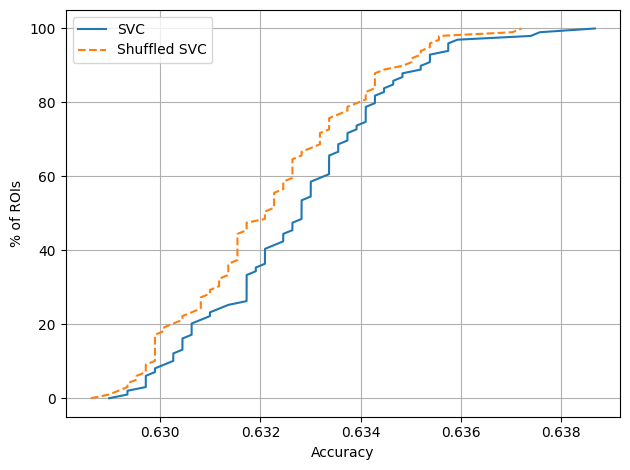

In [ ]:
# p-value
p_val = np.mean(acc_shuffled >= acc_real)
print(p_val)

plt.plot(sorted(acc_real), np.linspace(0, 100, len(acc_real)), label='SVC')
plt.plot(sorted(acc_shuffled), np.linspace(0, 100, len(acc_shuffled)), label='Shuffled SVC', linestyle='--')

plt.xlabel('Accuracy')
plt.ylabel('% of ROIs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [90]:
cumulative_count2 = np.arange(1, len(acc_real) + 1) / len(acc_real) * 100
cumulative_count2

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [91]:
df = pd.DataFrame({
    'Actual_Accuracy': sorted(acc_real),
    'Shuffled_Accuracy': sorted(acc_shuffled),
    'Cumulative': cumulative_count2
})
df.to_csv('cumulative_accuracy_runs_prelim.csv', index=False)



In [2]:
fed_folder = '/Users/savani/Documents/PangLab/TwoPhotonAnalysis/src/data/fed 30 sucrose'
fasted_folder = '/Users/savani/Documents/PangLab/TwoPhotonAnalysis/src/data/fasted 30 sucrose'
roi_folder = '/Users/savani/Documents/PangLab/TwoPhotonAnalysis/src/data/roi files'
all_avg_f, all_baseline_data, all_aligned_f, all_successful_f = t2p.process_2p_folder_tracked(fasted_folder, roi_folder, roi_name = 'fasted')
all_avg_fed, all_baseline_data_fed, all_aligned_fed, all_successful_fed = t2p.process_2p_folder_tracked(fed_folder, roi_folder, roi_name = 'fed')



glp10_fasted_30suc_L170P800_560um_040724-005
[3, 30, 21, 4, 7, 8, 12, 13, 14, 16, 20, 18, 19, 23, 24, 29, 28, 33, 0, 35, 37, 40, 42, 51, 55]
glp17_fasted30suc_L150P800_565um-032
[7, 6, 10, 12, 14, 13, 16, 15, 17, 21, 22, 18, 25, 23, 26, 8, 30, 29, 1, 35, 36, 37]
glp23_fasted_30suc_L155P800_575um-20250205-113-selected
[4, 5, 9, 12, 13, 14, 15, 17, 19, 20, 23, 25, 26]
glp4_fasted_nocues_L180_p815_650um031124-003
[2, 4, 3, 10, 11, 8, 13, 6, 16]
glp6_fastedNoCues_L180_P815_600um-_-03092024-1421-084
[30, 28, 0, 31, 6, 8, 10, 11, 14, 12, 18, 20, 19, 1, 23, 24, 25, 27, 26, 29, 33, 34, 36, 38, 40, 41, 42, 44, 43, 49, 51]
glp10_fed_30suc_L170P800_560um_040924-025
[0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 16, 19, 21, 22, 23, 24, 25, 27, 29, 31, 36, 38]
glp17_fed30suc_L150P800_565um_0613-020
[0, 1, 2, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29]
glp23_fed_30suc_L155P800_575um-20250203-112
[5, 6, 8, 9, 10, 11, 14, 15, 16, 20, 25, 26, 29]
glp4_fedNoCues_L180_P815_650u

Processing mouse with 25 cells...
Processing mouse with 22 cells...
Processing mouse with 13 cells...
Processing mouse with 9 cells...
Processing mouse with 31 cells...


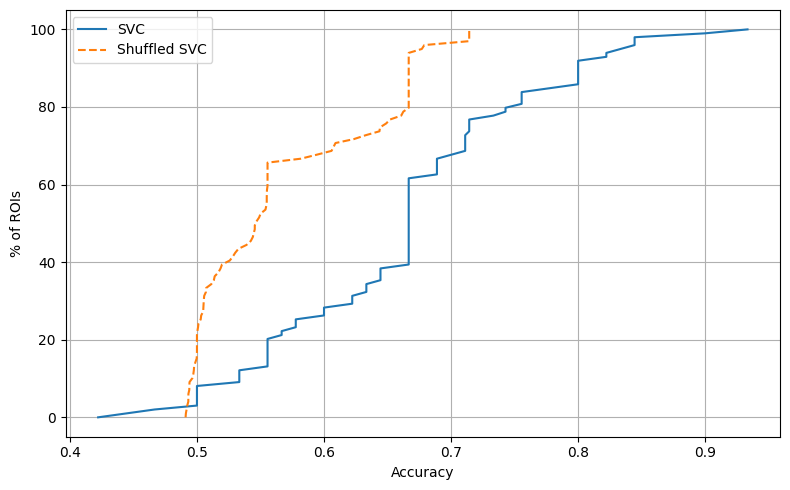

In [58]:
lick_frame = 75
post_window_s = 2
fps = 15
post_window_frames = int(post_window_s * fps)
frame_range = slice(lick_frame, lick_frame + post_window_frames)
n_permutations = 1000
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)


svc_grid = {
    "C": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
    "kernel": ["linear", "rbf"],
    "gamma": [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]  # only used for 'rbf'
}

svc_grid = {
    "C": [ 1e-2, 1e-1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": [1, 10, 100, 1000]  # only used for 'rbf'
}

# Initialize all results
svc_accs, svc_aucs, svc_pvals = [], [], []
svc_shuffled_accs = []  # store avg shuffled accuracy per neuron

fasted_list = all_aligned_f
fed_list = all_aligned_fed

# Loop over mice
for f_mouse, fe_mouse in zip(fasted_list, fed_list):
    ncells = min(f_mouse.shape[0], fe_mouse.shape[0])
    print(f"Processing mouse with {ncells} cells...")
    for cell_idx in range(ncells):
        f_data = f_mouse[cell_idx, :, frame_range].mean(axis=1) # avg across frames
        fe_data = fe_mouse[cell_idx, :, frame_range].mean(axis=1)

        X = np.concatenate([f_data, fe_data])[:, np.newaxis]
        y = np.array([0]*len(f_data) + [1]*len(fe_data))

        # Shuffle
        X, y = shuffle(X, y, random_state=42)

        # ----- SVC -----
        svc = GridSearchCV(SVC(probability=True), svc_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        svc.fit(X, y)
        svc_best = svc.best_estimator_

        # Cross-validated accuracy and AUROC
        accs = []
        aucs = []
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            svc_best.fit(X_train, y_train)
            accs.append(svc_best.score(X_test, y_test))
            aucs.append(roc_auc_score(y_test, svc_best.predict_proba(X_test)[:, 1]))

        svc_acc = np.mean(accs)
        svc_auc = np.mean(aucs)
        svc_accs.append(svc_acc)
        svc_aucs.append(svc_auc)

        # Permutation test
        perm_accs = []
        for _ in range(n_permutations):
            y_shuf = shuffle(y, random_state=None)
            perm_fold_acc = []
            for train_idx, test_idx in cv.split(X, y_shuf):
                svc_best.fit(X[train_idx], y_shuf[train_idx])
                perm_fold_acc.append(svc_best.score(X[test_idx], y_shuf[test_idx]))
            perm_accs.append(np.mean(perm_fold_acc))
        svc_pvals.append(np.mean(np.array(perm_accs) >= svc_acc))
        svc_shuffled_accs.append(np.mean(perm_accs))  # ⬅ store mean permuted accuracy


# ---- Cumulative Accuracy Plot ----
plt.figure(figsize=(8, 5))

# Actual SVC
sorted_accs = np.sort([x for x in svc_accs if not np.isnan(x)])
plt.plot(sorted_accs, np.linspace(0, 100, len(sorted_accs)), label='SVC')

# Shuffled SVC
sorted_shuf = np.sort([x for x in svc_shuffled_accs if not np.isnan(x)])
plt.plot(sorted_shuf, np.linspace(0, 100, len(sorted_shuf)), label='Shuffled SVC', linestyle='--')

plt.xlabel('Accuracy')
plt.ylabel('% of ROIs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
df = pd.DataFrame({
    'Actual_Accuracy': sorted(svc_accs),
    'Shuffled_Accuracy': sorted(svc_shuffled_accs),
    'Cumulative': cumulative_count
})
df.to_csv('cumulative_accuracy.csv', index=False)

